# Installs and imports

In [ ]:
!pip install --upgrade pip
!pip install sentencepiece
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 kB 11.3 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import AutoModelForSequenceClassification
from torch.utils.data import DataLoader
import numpy as np

# Data

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import jieba
import nltk
import re

In [ ]:
train = pd.read_csv('train.csv')

test = pd.read_csv('test.csv')
test = test[test['label']!= 0.0]

print('Train data ' + str(len(train)) + ' total')
print('Test data ' + str(len(test)) + ' total')

Train data 9491 total
Test data 3881 total


# Model

In [ ]:
CUDA = True
BATCH_SIZE = 32
MODEL = "cardiffnlp/twitter-xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModel.from_pretrained(MODEL)
if CUDA:
  model = model.to('cuda')
_ = model.eval()

Some weights of the model checkpoint at cardiffnlp/twitter-xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this mode

## Encode

In [ ]:
def encode(text, cuda=True):
  encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
  if cuda:
    encoded_input.to('cuda')
    output = model(**encoded_input)
    embeddings = output[0].detach().cpu().numpy()
  else:
    output = model(**encoded_input)
    embeddings = output[0].detach().numpy()

  embeddings = np.max(embeddings, axis=1)
  embeddings = np.mean(embeddings, axis=0)

  return embeddings

In [ ]:
def get_embedding_matrix(df):
  train_tweets = np.zeros((len(df),768))
  for i in range(0,len(df)):
    train_tweets[i,:] = encode(df.iloc[i]['text'])
  return train_tweets

In [ ]:
x_train = get_embedding_matrix(train)
x_test = get_embedding_matrix(test)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


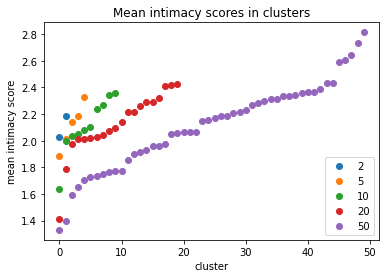

In [ ]:
K = [2,5,10,20,50]
for k in K:

  num_clasters = k
  kmeans = KMeans(n_clusters= num_clasters).fit(x_train)
  train['predictions'] = kmeans.predict(x_train)
  test['predictions'] = kmeans.predict(x_test)

  niz = []
  for i in range(0, num_clasters):
    #niz.append(np.mean(train[train['predictions']== i]['label']))
    niz.append(np.mean(test[test['predictions']== i]['label']))
  niz.sort()
  #print(niz)
  plt.scatter(range(0,k),niz)

plt.title('Mean intimacy scores in clusters')
plt.xlabel('cluster')
plt.ylabel('mean intimacy score')
plt.legend(K)

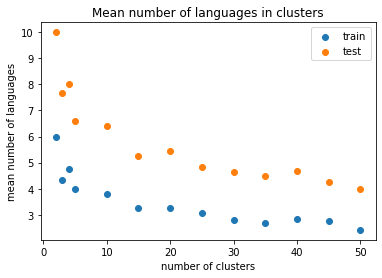

In [ ]:
K = [2,3,4,5,10,15,20,25,30,35,40,45,50]
average_number_languages_train = []
average_number_languages_test = []

for k in K:

  num_clasters = k
  kmeans = KMeans(n_clusters= num_clasters).fit(x_train)
  train['predictions'] = kmeans.predict(x_train)
  test['predictions'] = kmeans.predict(x_test)

  niz_train = []
  niz_test = []
  for i in range(0, num_clasters):
    niz_train.append(np.mean(len(train[train['predictions']== i]['language'].unique())))
    niz_test.append(np.mean(len(test[test['predictions']== i]['language'].unique())))
  average_number_languages_train.append(np.mean(niz_train))
  average_number_languages_test.append(np.mean(niz_test))

plt.scatter(K, average_number_languages_train)
plt.scatter(K, average_number_languages_test)
plt.title('Mean number of languages in clusters')
plt.xlabel('number of clusters')
plt.ylabel('mean number of languages')
plt.legend(['train', 'test'])